In [75]:
import pandas as pd
from scipy.stats import linregress
import numpy as np
import matplotlib.pyplot as plt

import requests
import json
import hvplot.pandas
from holoviews.operation.datashader import rasterize
import math

# Optionally, you can import the module below if you'd rather use the CDC's API to access data.
# However, you can't get an API Token without working for them, so I do not recommend doing things this way given their throttling limits.
# from sodapy import Socrata

In [114]:
# Get data
test_df = pd.read_csv("Resources/AGI+coords_data.csv")
# All money columns here in thousands of dollars
# Also dropped 3 rows because some ZIPs didn't have coordinates, apparently
test_df = test_df.drop(["Unnamed: 0", "index"], axis=1).dropna(axis="index", how="any").rename(columns={"N2":"Total Individuals", "A02650":"AGI"})
test_df

STATE  ZIPCODE  Total Individuals           AGI  \
0        MS    38738              140.0  5.770000e+02   
1        MO    64147              280.0  1.591000e+03   
2        SD    57794              390.0  3.206000e+03   
3        TN    37140              390.0  3.239000e+03   
4        MT    59444              270.0  2.321000e+03   
...     ...      ...                ...           ...   
27637    CA    94301            14750.0  1.527798e+07   
27638    CA    94027             5820.0  6.971688e+06   
27639    FL    33480             9050.0  1.466156e+07   
27640    CA    94104             1510.0  2.990505e+06   
27641    FL    33109              520.0  1.578682e+06   

       Total Income per Individual        lng       lat  
0                         4.121429  -90.53653  33.93049  
1                         5.682143  -94.54688  38.85387  
2                         8.220513 -102.40695  43.12071  
3                         8.305128  -87.65245  35.86345  
4                         8.596297 -111.34881  48.65227  
...                            ...        ...       ...  
27637                  1035.795390 -122.14992  37.44424  
27638                  1197.884536 -122.20313  37.45399  
27639                  1620.061768  -80.04075  26.69796  
27640                  1980.466887 -122.40211  37.79144  
27641                  3035.926924  -80.14197  25.76160  

[27639 rows x 7 columns]

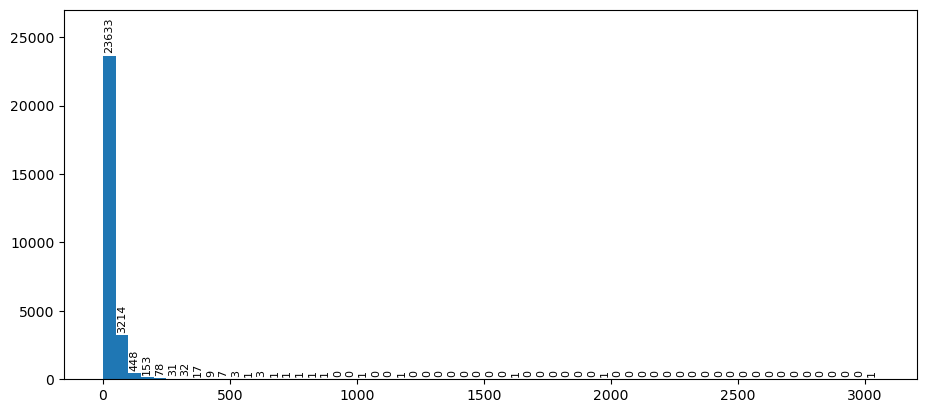

In [3]:
dbins = [i*50.0 for i in range(62)]
plt.figure(figsize=(11,4.8)) 
counts, bins, bars = plt.hist(test_df["Total Income per Individual"], bins=dbins)
plt.bar_label(bars, fontsize=8, rotation="vertical", padding=2)
plt.ylim(0,27000)

plt.show()
# If you're wondering why the chart is so wide, it's because wealth disparity sucks and the Income/Capita in Miami Beach is $3 million.

In [4]:
# Map starts out pretty far because we're also including Hawaii and Alaska
# Non-datashaded map works, but it's super laggy with 27k points, so we'll stick with this for big visualizations
money_plot = test_df.hvplot.points(
    "lng",
    "lat",
    geo = True,
    tiles = "CartoLight",
    frame_width = 800,
    frame_height = 400,
    scale = .7,
    color = "Total Income per Individual",
    cmap = "hot_r",
    colorbar = True,
    datashade=True,
    dynspread=True,
    xlabel="Longitude",
    ylabel="Latitude",
    title= "ZIPCODES by MONEY"
)

money_plot

:DynamicMap   []
   :Overlay
      .Tiles.I :Tiles   [x,y]
      .RGB.I   :RGB   [lng,lat]   (R,G,B,A)

In [5]:
# State View
teststate_df = test_df.loc[test_df["STATE"]=="NY"]

money_plot = teststate_df.hvplot.points(
    "lng",
    "lat",
    geo = True,
    tiles = "CartoLight",
    frame_width = 800,
    frame_height = 400,
    scale = .7,
    color = "Total Income per Individual",
    cmap = "hot_r",
    colorbar = True,
    xlabel="Longitude",
    ylabel="Latitude",
    title= "ZIPCODES by MONEY"
)

money_plot

:Overlay
   .Tiles.I  :Tiles   [x,y]
   .Points.I :Points   [lng,lat]   (Total Income per Individual)

In [115]:
# TODO: make correlation matrix between AGI/capita and the other columns from the medical data set
# Columns I'm interested in: any columns with a correlation coefficient of >0.6 
med_df = pd.read_csv("Resources/PLACES__ZCTA_Data__GIS_Friendly_Format___2022_release.csv")
med_df

# TotalPopulation and Geolocation columns match up pretty well with the tax information dataset, so these columns are safe to ignore

ZCTA5  TotalPopulation  ACCESS2_CrudePrev ACCESS2_Crude95CI  \
0       8065             7398               11.8      (10.6, 13.0)   
1      28443            17512               13.7      (12.4, 15.1)   
2       3103            36476               16.1      (15.2, 17.1)   
3       4042             4281               12.0      ( 9.6, 14.7)   
4       1109            30250               14.1      (13.2, 15.1)   
...      ...              ...                ...               ...   
32404  90249            26669               15.7      (14.7, 16.8)   
32405  92551            30815               21.0      (19.7, 22.3)   
32406  98226            41235               10.3      ( 9.7, 11.0)   
32407  87553             1209               19.8      (16.5, 23.5)   
32408  95620            20553               15.1      (13.7, 16.5)   

       ARTHRITIS_CrudePrev ARTHRITIS_Crude95CI  BINGE_CrudePrev  \
0                     23.6        (22.8, 24.3)             17.0   
1                     25.2        (24.5, 25.9)             16.3   
2                     23.4        (22.9, 23.8)             18.0   
3                     25.6        (24.2, 26.9)             16.6   
4                     24.6        (24.3, 24.9)             14.8   
...                    ...                 ...              ...   
32404                 17.9        (17.5, 18.3)             15.6   
32405                 17.1        (16.9, 17.4)             19.0   
32406                 24.8        (24.3, 25.3)             19.0   
32407                 25.2        (24.2, 26.3)             11.9   
32408                 19.4        (19.0, 19.9)             19.4   

      BINGE_Crude95CI  BPHIGH_CrudePrev BPHIGH_Crude95CI  ...  \
0        (16.8, 17.2)               NaN              NaN  ...   
1        (16.1, 16.5)              33.1     (32.3, 33.8)  ...   
2        (17.8, 18.2)              29.4     (29.0, 29.8)  ...   
3        (16.0, 17.2)              29.7     (28.3, 31.1)  ...   
4        (14.5, 14.9)              33.9     (33.6, 34.2)  ...   
...               ...               ...              ...  ...   
32404    (15.5, 15.7)              29.8     (29.4, 30.2)  ...   
32405    (18.8, 19.2)              27.4     (27.1, 27.7)  ...   
32406    (18.8, 19.2)              29.8     (29.3, 30.2)  ...   
32407    (11.5, 12.1)              35.0     (33.8, 36.2)  ...   
32408    (18.9, 19.8)              25.1     (24.6, 25.6)  ...   

       OBESITY_Crude95CI PHLTH_CrudePrev  PHLTH_Crude95CI SLEEP_CrudePrev  \
0           (31.5, 33.0)             9.2     ( 8.7,  9.7)            36.9   
1           (27.3, 28.8)             9.2     ( 8.7,  9.7)            32.0   
2           (32.4, 33.4)            11.3     (10.8, 11.7)            36.2   
3           (29.3, 32.5)             8.5     ( 7.5,  9.5)            33.1   
4           (37.7, 38.6)            12.4     (12.0, 12.8)            42.2   
...                  ...             ...              ...             ...   
32404       (29.4, 30.4)             9.8     ( 9.4, 10.2)            35.6   
32405       (36.6, 37.4)            11.0     (10.6, 11.4)            37.6   
32406       (27.4, 28.2)            10.4     (10.1, 10.7)            28.4   
32407       (27.8, 29.6)            13.9     (13.2, 14.7)            32.4   
32408       (31.2, 32.5)            10.4     ( 9.9, 10.8)            33.9   

       SLEEP_Crude95CI STROKE_CrudePrev  STROKE_Crude95CI TEETHLOST_CrudePrev  \
0         (36.0, 37.7)              2.8      ( 2.7,  3.0)                12.4   
1         (31.2, 32.8)              2.8      ( 2.7,  3.0)                10.3   
2         (35.7, 36.7)              2.8      ( 2.6,  2.9)                17.0   
3         (31.4, 34.7)              2.4      ( 2.2,  2.7)                13.0   
4         (41.6, 42.7)              4.0      ( 3.8,  4.1)                25.6   
...                ...              ...               ...                 ...   
32404     (35.0, 36.1)              3.0      ( 2.9,  3.2)                11.2   
32405  

In [7]:
med_df.loc[med_df["ZCTA5"]==33109]

ZCTA5  TotalPopulation  ACCESS2_CrudePrev ACCESS2_Crude95CI  \
16099  33109              594               16.7      (13.6, 20.1)   

       ARTHRITIS_CrudePrev ARTHRITIS_Crude95CI  BINGE_CrudePrev  \
16099                 30.8        (28.6, 33.0)             11.0   

      BINGE_Crude95CI  BPHIGH_CrudePrev BPHIGH_Crude95CI  ...  \
16099    (10.7, 11.2)              40.9     (38.8, 42.9)  ...   

       OBESITY_Crude95CI PHLTH_CrudePrev  PHLTH_Crude95CI SLEEP_CrudePrev  \
16099       (24.0, 26.4)            12.5     (10.9, 14.3)            30.8   

       SLEEP_Crude95CI STROKE_CrudePrev  STROKE_Crude95CI TEETHLOST_CrudePrev  \
16099     (29.3, 32.1)              4.3      ( 3.5,  5.2)                11.5   

       TEETHLOST_Crude95CI                       Geolocation  
16099         ( 6.6, 18.1)  POINT (-80.14132101 25.75993225)  

[1 rows x 63 columns]

In [8]:
# We'll ignore any of the CI columns and keep the ZCTA5 column, so there should be 31 columns left
prev_df = med_df.filter(like="Prev")
prev_df.insert(0, "ZIPCODE", med_df.loc[:, "ZCTA5"])
a_df = prev_df.dropna(axis="index", how="any")
medical_df = test_df.merge(a_df, how="left", on="ZIPCODE").dropna(axis="index", how="any")\
.rename(columns=
        {# Health Outcomes
         "ARTHRITIS_CrudePrev":"Arthritis", "BPHIGH_CrudePrev":"High Blood Pressure", "CANCER_CrudePrev":"(Non-Skin) Cancer", 
         "CASTHMA_CrudePrev":"Current Asthma", "CERVICAL_CrudePrev":"Cervical Cancer (Adult Women)", "CHD_CrudePrev":"Coronary Heart Disease",
         "COPD_CrudePrev":"Chronic Obstructive Pulmonary Disease", "DEPRESSION_CrudePrev":"Depression", "DIABETES_CrudePrev":"Diabetes",
         "HIGHCHOL_CrudePrev":"High Cholesterol", "KIDNEY_CrudePrev":"Chronic Kidney Disease", "OBESITY_CrudePrev":"Obesity", "STROKE_CrudePrev":"Stroke", "TEETHLOST_CrudePrev":"All Teeth Lost (Older Adults)",
         # Prevention 
         "ACCESS2_CrudePrev":"Lacking Health Insurance", "BPMED_CrudePrev":"Taking Medicine for High Blood Pressure",
         "CHECKUP_CrudePrev":"Routine Health Checkups", "CHOLSCREEN_CrudePrev":"Cholesterol Screening", 
         "COLON_SCREEN_CrudePrev":"FOBT/Colon Screening (Older Adults)",  "COREM_CrudePrev":"Core Clinical Prevention (Older Men)", "COREW_CrudePrev":"Core Clinical Prevention (Older Women)",
         "DENTAL_CrudePrev":"Dentist Visits", "MAMMOUSE_CrudePrev":"Mammography (Older Women)",
         # Health Risk Behaviors
         "BINGE_CrudePrev":"Binge Drinking", "CSMOKING_CrudePrev":"Currently Smoking", "LPA_CrudePrev":"No Leisure-Time Physical Activity",
         "SLEEP_CrudePrev":"Less than 7 Hours of Sleep", 
         # Health Status
         "GHLTH_CrudePrev":"'Fair' or 'Poor' Self-Rated Health Status", "MHLTH_CrudePrev":"'Poor' Self-Rated Mental Health Status", 
         "PHLTH_CrudePrev":"'Poor' Self-Rated Physical Health Status"
        })

# Note: Each of the Health Outcomes columns is the "Crude Prevalence" of that particular health phenomenon
# Note: Unless mentioned otherwise, these stats are measured for adults
medical_df

STATE  ZIPCODE  Total Individuals           AGI  \
0        MS    38738              140.0  5.770000e+02   
1        MO    64147              280.0  1.591000e+03   
2        SD    57794              390.0  3.206000e+03   
3        TN    37140              390.0  3.239000e+03   
4        MT    59444              270.0  2.321000e+03   
...     ...      ...                ...           ...   
27634    CA    94301            14750.0  1.527798e+07   
27635    CA    94027             5820.0  6.971688e+06   
27636    FL    33480             9050.0  1.466156e+07   
27637    CA    94104             1510.0  2.990505e+06   
27638    FL    33109              520.0  1.578682e+06   

       Total Income per Individual        lng       lat  \
0                         4.121429  -90.53653  33.93049   
1                         5.682143  -94.54688  38.85387   
2                         8.220513 -102.40695  43.12071   
3                         8.305128  -87.65245  35.86345   
4                         8.596297 -111.34881  48.65227   
...                            ...        ...       ...   
27634                  1035.795390 -122.14992  37.44424   
27635                  1197.884536 -122.20313  37.45399   
27636                  1620.061768  -80.04075  26.69796   
27637                  1980.466887 -122.40211  37.79144   
27638                  3035.926924  -80.14197  25.76160   

       Lacking Health Insurance  Arthritis  Binge Drinking  ...  \
0                          32.1       18.5            17.6  ...   
1                          19.1        9.0            21.1  ...   
2                          20.0       24.0            19.7  ...   
3                          27.6       17.0            19.5  ...   
4                          15.2       26.5            22.4  ...   
...                         ...        ...             ...  ...   
27634                       4.9       19.2            18.2  ...   
27635                       4.9       22.6            15.6  ...   
27636                      10.7       32.9             8.6  ...   
27637                      10.7       20.3            13.5  ...   
27638                      16.7       30.8            11.0  ...   

       High Cholesterol  Chronic Kidney Disease  \
0                  28.1                     2.6   
1                  13.2                     1.2   
2                  24.3                     4.4   
3                  25.8                     2.0   
4                  31.6                     3.0   
...                 ...                     ...   
27634              29.0                     2.4   
27635              36.9                     2.7   
27636              42.1                     4.4   
27637              34.1                     2.9   
27638              39.6                     4.1   

       No Leisure-Time Physical Activity  Mammography (Older Women)  \
0                                   33.0                       79.5   
1                                   22.9                       81.3   
2                                   38.5                       73.4   
3                                   28.5                       70.0   
4                                   23.5                       70.1   
...                                  ...                        ...   
27634                               12.7                       76.6   
27635                               12.7                       76.1   
27636                               20.2                       79.3   
27637                               22.5                       65.4   
27638                               26.2                       76.0   

       'Poor' Self-Rated Mental Health Status  Obesity  \
0                                        15.5     49.2   
1                                        21.9     31.9   
2                                        20.0     45.5   
3                                        16.6     43.0   
4                                        15.2     3

In [9]:
# Correlation Table here
corr_table = medical_df.drop(labels=["STATE", "ZIPCODE", "Total Individuals", "AGI", "lng", "lat"], axis="columns").corr(method='pearson')
corr_table

Total Income per Individual  \
Total Income per Individual                                   1.000000   
Lacking Health Insurance                                     -0.231399   
Arthritis                                                    -0.220412   
Binge Drinking                                                0.071443   
High Blood Pressure                                          -0.258748   
Taking Medicine for High Blood Pressure                      -0.085161   
(Non-Skin) Cancer                                             0.065474   
Current Asthma                                               -0.285666   
Cervical Cancer (Adult Women)                                 0.246820   
Coronary Heart Disease                                       -0.231022   
Routine Health Checkups                                      -0.055448   
Cholesterol Screening                                         0.273193   
FOBT/Colon Screening (Older Adults)                           0.214133   
Chronic Obstructive Pulmonary Disease                        -0.306645   
Core Clinical Prevention (Older Men)                          0.239999   
Core Clinical Prevention (Older Women)                        0.251306   
Currently Smoking                                            -0.414348   
Dentist Visits                                                0.363755   
Depression                                                   -0.256215   
Diabetes                                                     -0.290737   
'Fair' or 'Poor' Self-Rated Health Status                    -0.339200   
High Cholesterol                                             -0.122255   
Chronic Kidney Disease                                       -0.246660   
No Leisure-Time Physical Activity                            -0.374376   
Mammography (Older Women)                                     0.156979   
'Poor' Self-Rated Mental Health Status                       -0.329701   
Obesity                                                      -0.418869   
'Poor' Self-Rated Physical Health Status                     -0.350397   
Less than 7 Hours of Sleep                                   -0.308978   
Stroke                                                       -0.279330   
All Teeth Lost (Older Adults)                                -0.377696   

                                           Lacking Health Insurance  \
Total Income per Individual                               -0.231399   
Lacking Health Insurance                                   1.000000   
Arthritis                                                 -0.048930   
Binge Drinking                                            -0.237597   
High Blood Pressure                                        0.271049   
Taking Medicine for High Blood Pressure                   -0.088136   
(Non-Skin) Cancer                                         -0.375352   
Current Asthma                                             0.109077   
Cervical Cancer (Adult Women)                             -0.615151   
Coronary Heart Disease                                     0.166480   
Routine Health Checkups                                   -0.151275   
Cholesterol Screening                                     -0.460773   
FOBT/Colon Screening (Older Adults)                       -0.509566   
Chronic Obstructive Pulmonary Disease                      0.233173   
Core Clinical Prevention (Older Men)                      -0.515598   
Core Clinical Prevention (Older Women)                    -0.510138   
Currently Smoking                                          0.383959   
Dentist Visits                                            -0.749444   
Depression                                                 0.141787   
Diabetes                                                   0.524238   
'Fair' or 'Poor' Self-Rated Health Status                  0.644541   
High Cholesterol                                           0.053484   
Chronic Kidney Disease                   

In [10]:
# Ordered by strength of correlation (absolute value used). Note that none of the correlations here are stronger than 0.5
# However, because there could still be the chance that none of the graphs are LINEARLY correlated, it's still important to graph them somewhere and see if there are other relationships that make sense
strength = corr_table.loc[:, "Total Income per Individual"].abs().sort_values(ascending=False)
strength

Total Income per Individual                  1.000000
Obesity                                      0.418869
Currently Smoking                            0.414348
All Teeth Lost (Older Adults)                0.377696
No Leisure-Time Physical Activity            0.374376
Dentist Visits                               0.363755
'Poor' Self-Rated Physical Health Status     0.350397
'Fair' or 'Poor' Self-Rated Health Status    0.339200
'Poor' Self-Rated Mental Health Status       0.329701
Less than 7 Hours of Sleep                   0.308978
Chronic Obstructive Pulmonary Disease        0.306645
Diabetes                                     0.290737
Current Asthma                               0.285666
Stroke                                       0.279330
Cholesterol Screening                        0.273193
High Blood Pressure                          0.258748
Depression                                   0.256215
Core Clinical Prevention (Older Women)       0.251306
Cervical Cancer (Adult Women

In [11]:
strength.index
# This is an array of sorts, so you can access (for example) "Total Income per Individual" by calling strength.index[0]

Index(['Total Income per Individual', 'Obesity', 'Currently Smoking',
       'All Teeth Lost (Older Adults)', 'No Leisure-Time Physical Activity',
       'Dentist Visits', ''Poor' Self-Rated Physical Health Status',
       ''Fair' or 'Poor' Self-Rated Health Status',
       ''Poor' Self-Rated Mental Health Status', 'Less than 7 Hours of Sleep',
       'Chronic Obstructive Pulmonary Disease', 'Diabetes', 'Current Asthma',
       'Stroke', 'Cholesterol Screening', 'High Blood Pressure', 'Depression',
       'Core Clinical Prevention (Older Women)',
       'Cervical Cancer (Adult Women)', 'Chronic Kidney Disease',
       'Core Clinical Prevention (Older Men)', 'Lacking Health Insurance',
       'Coronary Heart Disease', 'Arthritis',
       'FOBT/Colon Screening (Older Adults)', 'Mammography (Older Women)',
       'High Cholesterol', 'Taking Medicine for High Blood Pressure',
       'Binge Drinking', '(Non-Skin) Cancer', 'Routine Health Checkups'],
      dtype='object')

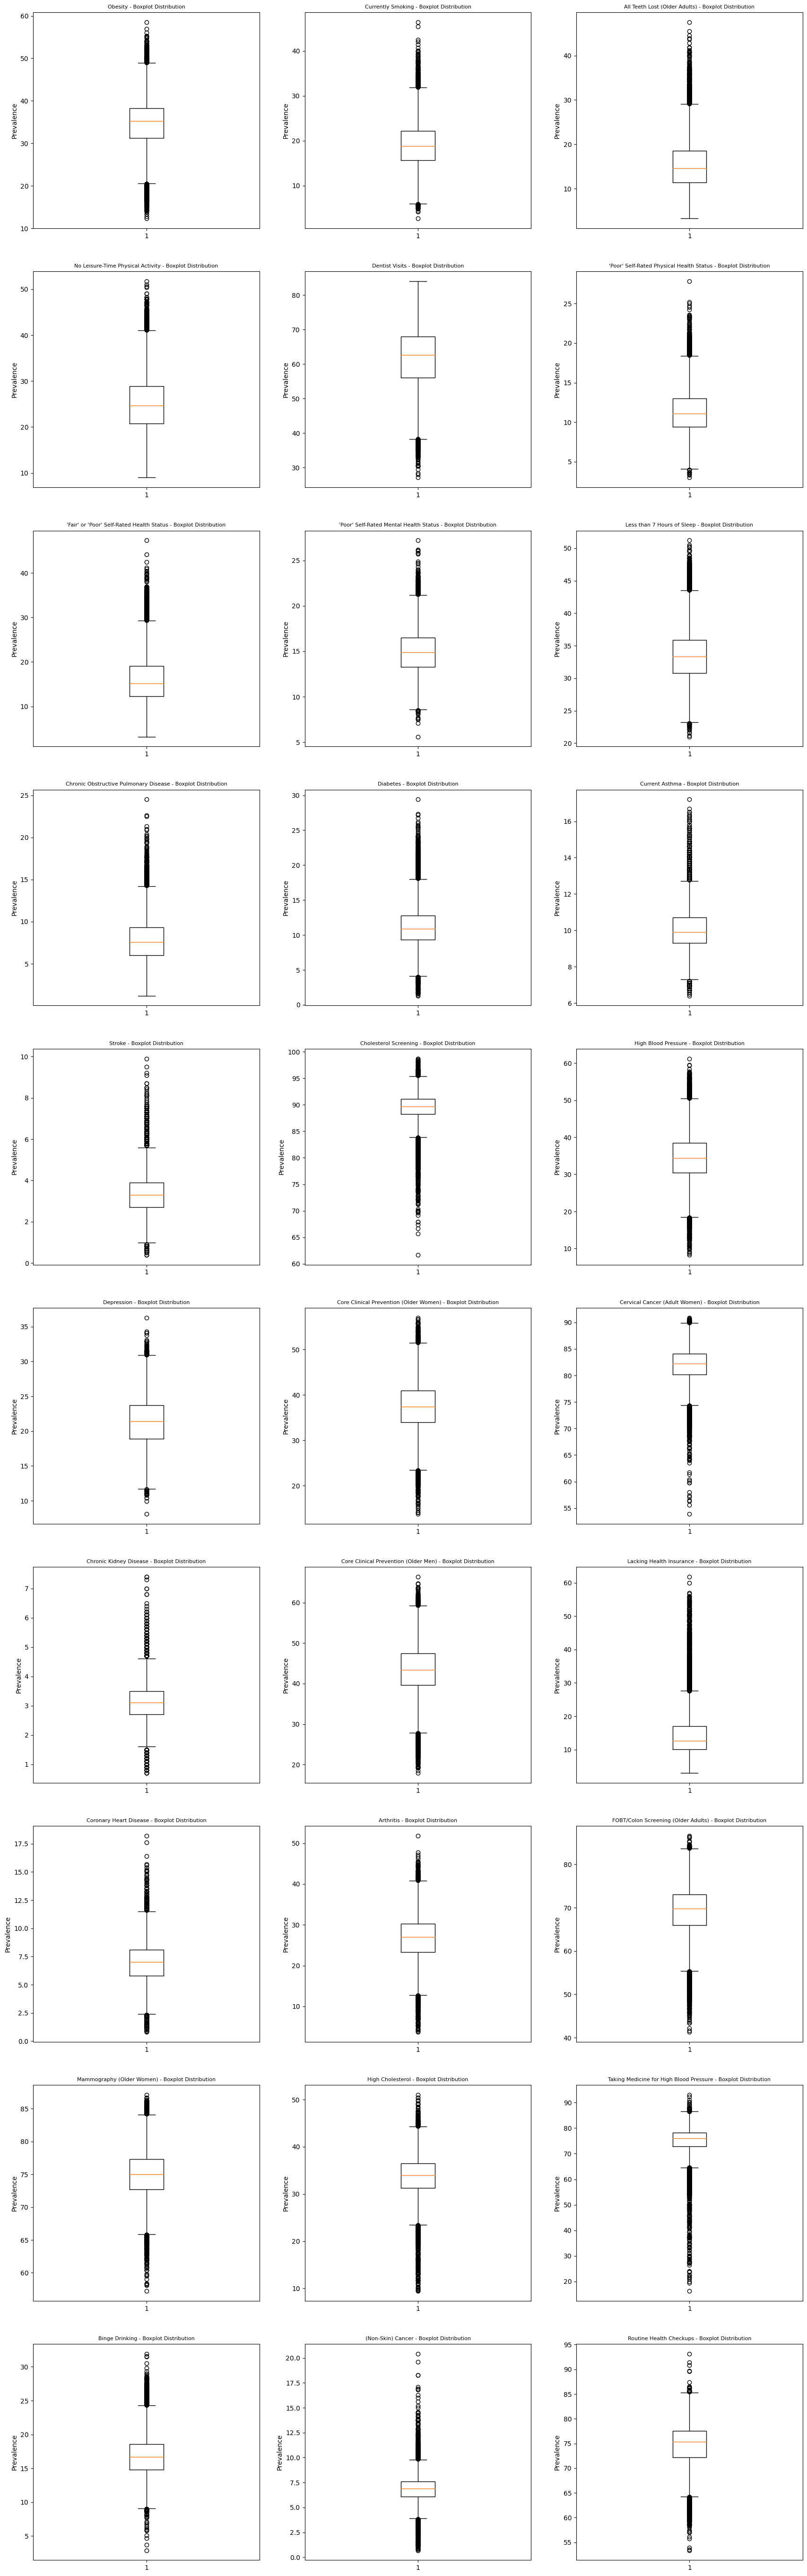

In [12]:
# Boxplots here

rows = 10
cols = 3
fig, axs = plt.subplots(rows, cols)
fig.set_figheight(7*rows)
fig.set_figwidth(7*cols)
for i in range(rows):
    for j in range(cols):
        X = strength.index[i*cols+j+1]
        axs[i, j].boxplot(medical_df[X])
        axs[i, j].set_title(f"{X} - Boxplot Distribution", fontdict={"fontsize":8})
        axs[i, j].set_ylabel("Prevalence")
plt.show()

In [13]:
# Define a function to create Linear Regression plots because this is a mouthful
# Takes in independent and dependent variables as series and spits back out a linear regression equation
# As we'll be needing Pearson-R stuff, it's in our best interest to use the more unruly SciPy method
def reg_this(x, y):
    result = linregress(x, y)
    
    # Access values with reg_this(x,y).slope, .intercept, .rvalue (Pearson-R), .pvalue (Hypothesis test for statistical significance of discovered regression), .stderr (Standard Error)
    return result

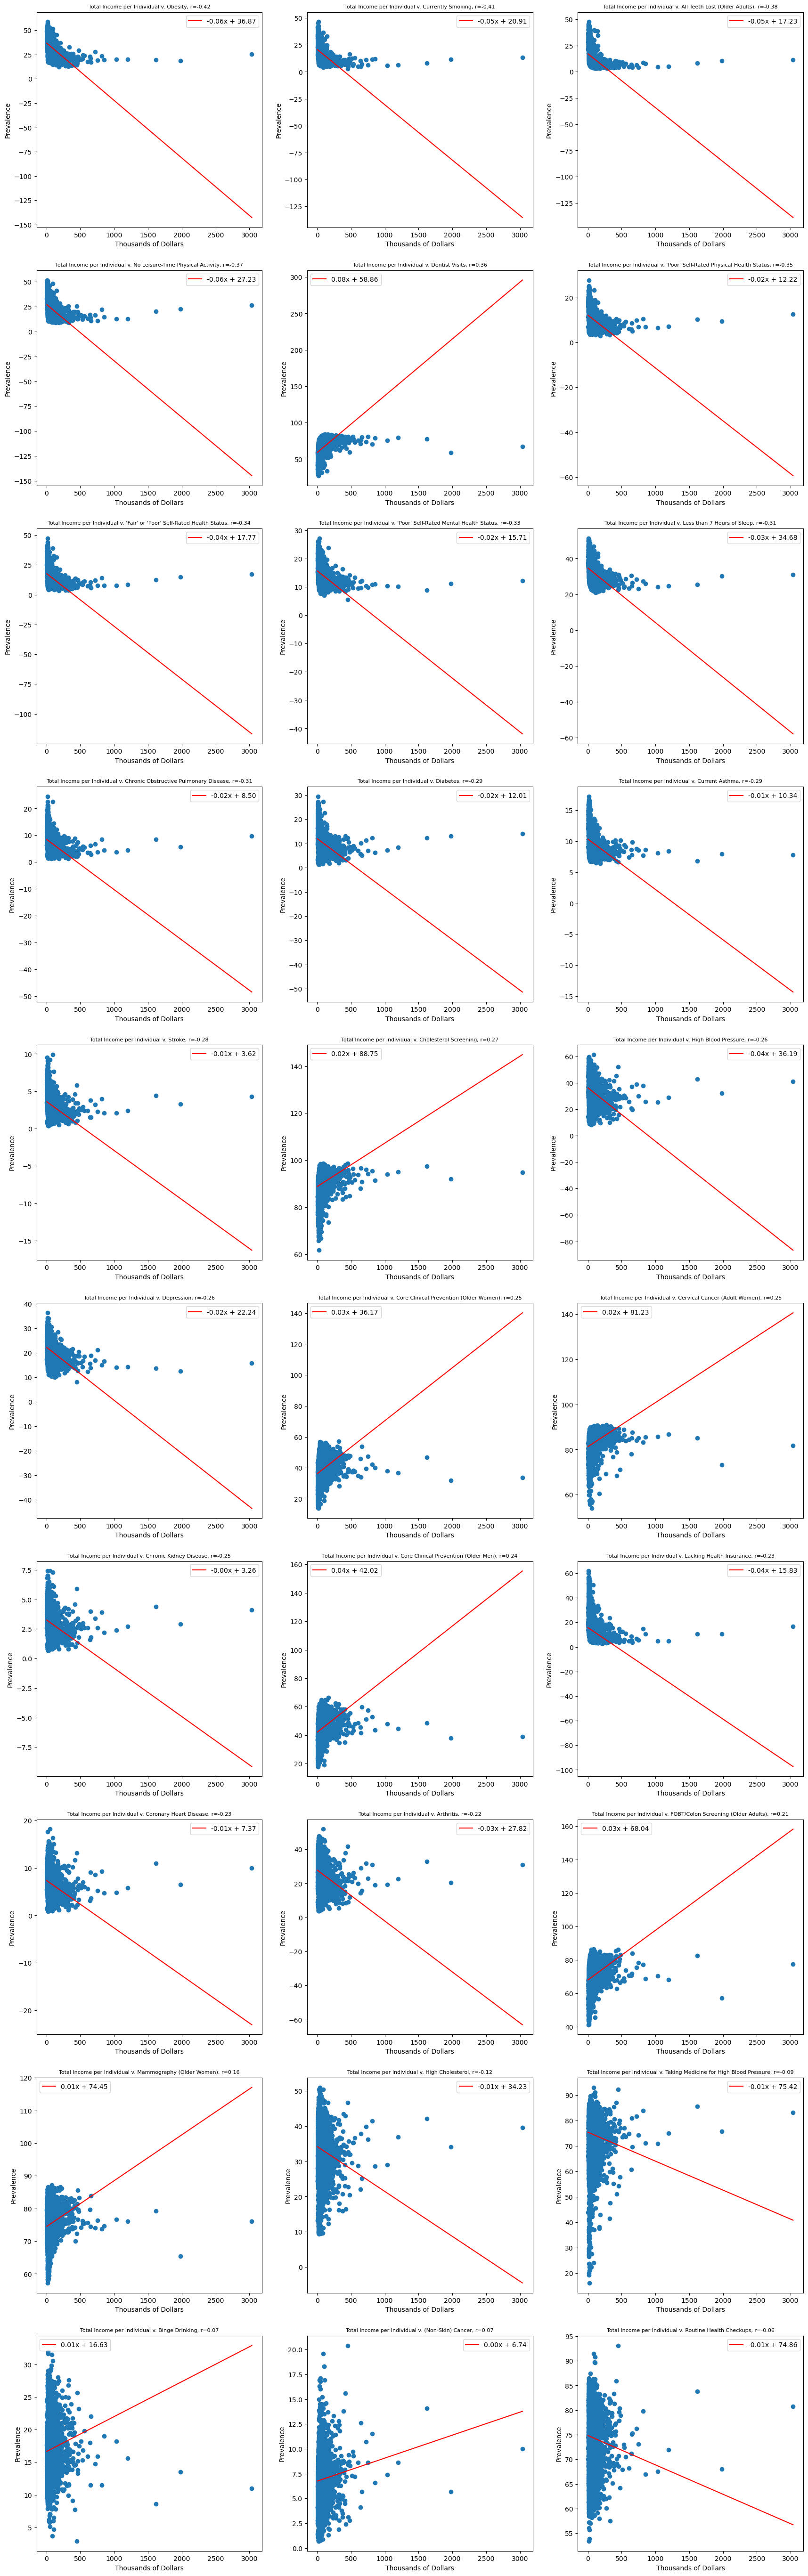

In [118]:
# Results indicate that we have to remove outliers for the charts to make sense, probably
# Results not necessarily best represented by linear models of regression

rows = 10
cols = 3
fig, axs = plt.subplots(rows, cols)
fig.set_figheight(7*rows)
fig.set_figwidth(7*cols)
for i in range(rows):
    for j in range(cols):
        X = strength.index[0]
        Y = strength.index[i*cols+j+1]
        result = reg_this(medical_df[X], medical_df[Y])
        axs[i, j].scatter(medical_df[X], medical_df[Y])
        axs[i, j].plot(medical_df[X], (result.slope*medical_df[X]+result.intercept), label = f"{result.slope:.2f}x + {result.intercept:.2f}", color = "red")
        axs[i, j].set_title(f"{X} v. {Y}, r={result.rvalue:.2f}", fontdict={"fontsize":8})
        axs[i, j].set_xlabel("Thousands of Dollars")
        axs[i, j].set_ylabel("Prevalence")
        axs[i, j].legend(loc="best")
plt.savefig("Results/unculled_regressions_AGIvHealth.png")
plt.show()

In [39]:
# State View
teststate_df = medical_df.loc[medical_df["STATE"]=="NY"]

money_plot = teststate_df.hvplot.points(
    "lng",
    "lat",
    geo = True,
    tiles = "CartoLight",
    frame_width = 800,
    frame_height = 400,
    scale = 1,
    color = "Total Income per Individual",
    colorbar = True,
    size="(Non-Skin) Cancer",
    xlabel="Longitude",
    ylabel="Latitude",
    title= "ZIPCODES by AGI/Capita (Color) and Cancer Prevalence (Size)"
)

money_plot

:Overlay
   .Tiles.I  :Tiles   [x,y]
   .Points.I :Points   [lng,lat]   (Total Income per Individual,(Non-Skin) Cancer)

## Redo, but with top 100filtered out

In [116]:
culled_df = medical_df.iloc[:-100, :]
culled_df.to_csv("Resources/AGI+medical_data.csv")

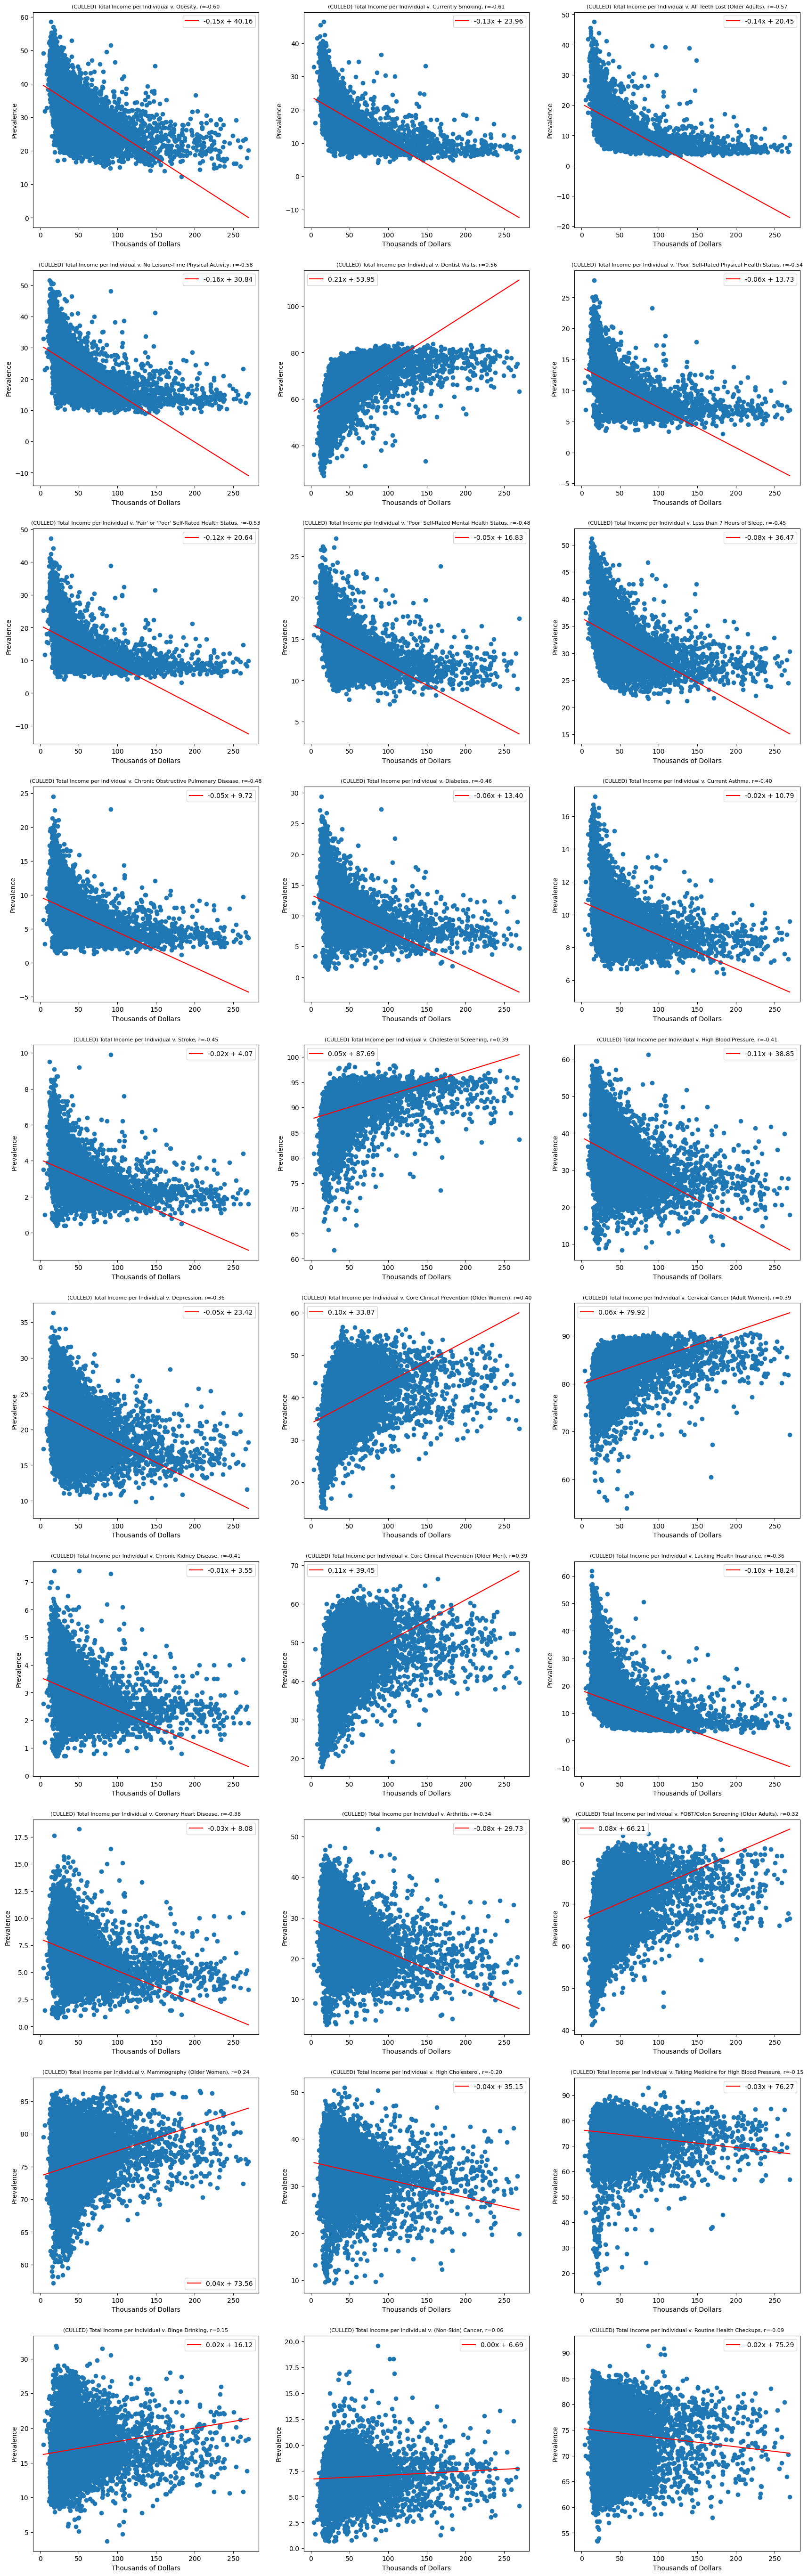

In [119]:
# Results indicate that we have to remove outliers for the charts to make sense, probably
# Results not necessarily best represented by linear models of regression

rows = 10
cols = 3
fig, axs = plt.subplots(rows, cols)
fig.set_figheight(7*rows)
fig.set_figwidth(7*cols)
for i in range(rows):
    for j in range(cols):
        X = strength.index[0]
        Y = strength.index[i*cols+j+1]
        result = reg_this(culled_df[X], culled_df[Y])
        axs[i, j].scatter(culled_df[X], culled_df[Y])
        axs[i, j].plot(culled_df[X], (result.slope*culled_df[X]+result.intercept), label = f"{result.slope:.2f}x + {result.intercept:.2f}", color = "red")
        axs[i, j].set_title(f"(CULLED) {X} v. {Y}, r={result.rvalue:.2f}", fontdict={"fontsize":8})
        axs[i, j].set_xlabel("Thousands of Dollars")
        axs[i, j].set_ylabel("Prevalence")
        axs[i, j].legend(loc="best")
plt.savefig("Results/culled_regressions_AGIvHealth.png")
plt.show()

In [44]:
strength.index

Index(['Total Income per Individual', 'Obesity', 'Currently Smoking',
       'All Teeth Lost (Older Adults)', 'No Leisure-Time Physical Activity',
       'Dentist Visits', ''Poor' Self-Rated Physical Health Status',
       ''Fair' or 'Poor' Self-Rated Health Status',
       ''Poor' Self-Rated Mental Health Status', 'Less than 7 Hours of Sleep',
       'Chronic Obstructive Pulmonary Disease', 'Diabetes', 'Current Asthma',
       'Stroke', 'Cholesterol Screening', 'High Blood Pressure', 'Depression',
       'Core Clinical Prevention (Older Women)',
       'Cervical Cancer (Adult Women)', 'Chronic Kidney Disease',
       'Core Clinical Prevention (Older Men)', 'Lacking Health Insurance',
       'Coronary Heart Disease', 'Arthritis',
       'FOBT/Colon Screening (Older Adults)', 'Mammography (Older Women)',
       'High Cholesterol', 'Taking Medicine for High Blood Pressure',
       'Binge Drinking', '(Non-Skin) Cancer', 'Routine Health Checkups'],
      dtype='object')

In [123]:
# Plug in desired column in X and your max point size in Y
X = "(Non-Skin) Cancer"
Y = 300

test_df = culled_df.sort_values(X, ascending=True)[["Total Income per Individual", "STATE", X, "lng","lat"]]

# This is just here so people can see the correlation coefficient conveniently
result = reg_this(test_df["Total Income per Individual"], test_df[X])

# State-level views are used because a full nationwide view typically lags too much
# You can use "test_df.loc[~test_df["STATE"].isin(["AK","HI"])]" to see the mainland
#test_df = test_df.loc[test_df["STATE"]=="NY"]
test_df = test_df.loc[~test_df["STATE"].isin(["AK","HI"])]

# A new column is created such that the bigger prevalences are scaled closer to Max Point Size Y while the smaller points are scaled closer to 0
# This accentuates the differences in point size for the purposes of these visualizations
test_df["testing"] = (test_df[X]-test_df[X].min()+0.01)**math.log(Y, test_df[X].max()-test_df[X].min())

money_plot = test_df.hvplot.points(
    "lng",
    "lat",
    geo = True,
    tiles = "CartoLight",
    frame_width = 800,
    frame_height = 400,
    color = "Total Income per Individual",
    alpha = .7,
    colorbar = True,
    size = "testing",
    xlabel="Longitude",
    ylabel="Latitude",
    title= f"(CULLED) ZIPCODES by MONEY (Color) and {X} (Size), r={result.rvalue:.2f}"
)

print(f"{X} Prevalence from {test_df[X].max()} to {test_df[X].min()}")
money_plot

(Non-Skin) Cancer Prevalence from 19.6 to 0.7


:Overlay
   .Tiles.I  :Tiles   [x,y]
   .Points.I :Points   [lng,lat]   (Total Income per Individual,testing)